## Does the position of an item affect the likelihood of a user to click on it

#### Tzuf Raif 318244647 & Liron Paz 311280283

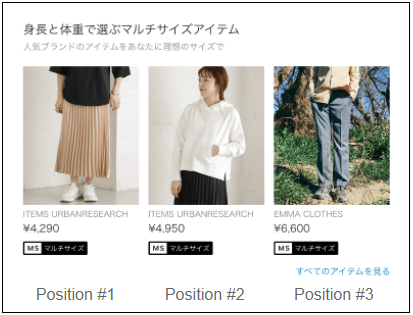

# Downloading the data from github

https://github.com/st-tech/zr-obp/tree/master/obd

In [1]:
!wget https://research.zozo.com/data_release/open_bandit_dataset.zip

--2022-08-28 19:26:12--  https://research.zozo.com/data_release/open_bandit_dataset.zip
Resolving research.zozo.com (research.zozo.com)... 13.225.142.98, 13.225.142.99, 13.225.142.74, ...
Connecting to research.zozo.com (research.zozo.com)|13.225.142.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 412931917 (394M) [application/zip]
Saving to: ‘open_bandit_dataset.zip’

open_bandit_dataset 100%[===================>] 393.80M  35.2MB/s    in 12s     

2022-08-28 19:26:25 (32.6 MB/s) - ‘open_bandit_dataset.zip’ saved [412931917/412931917]



In [ ]:
!unzip open_bandit_dataset.zip

Archive:  open_bandit_dataset.zip
Made with MacWinZipper (http://tidajapan.com/macwinzipper)
  inflating: open_bandit_dataset/README  
  inflating: open_bandit_dataset/bts/all/item_context.csv  
  inflating: open_bandit_dataset/bts/all/all.csv  
  inflating: open_bandit_dataset/bts/men/item_context.csv  
  inflating: open_bandit_dataset/bts/men/men.csv  
  inflating: open_bandit_dataset/bts/women/item_context.csv  
  inflating: open_bandit_dataset/bts/women/women.csv  
  inflating: open_bandit_dataset/VERSION  
  inflating: open_bandit_dataset/random/all/item_context.csv  
  inflating: open_bandit_dataset/random/all/all.csv  
  inflating: open_bandit_dataset/random/men/item_context.csv  
  inflating: open_bandit_dataset/random/men/men.csv  
  inflating: open_bandit_dataset/random/women/item_context.csv  
  inflating: open_bandit_dataset/random/women/women.csv  


# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot
from plotly.subplots import make_subplots
from datetime import datetime
from scipy.interpolate import interp1d
from datetime import datetime
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.isotonic import IsotonicRegression
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing, metrics
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import warnings
from datetime import datetime
from sklearn.metrics import roc_curve, auc


warnings.filterwarnings("ignore")

# Data Preprocessing

In [ ]:
def load_dataset(df_path, item_path, rows=None):
  df = pd.read_csv(df_path, nrows=rows)
  items_df = pd.read_csv(item_path)
  df.drop('Unnamed: 0', inplace=True, axis=1)
  df = df.join(items_df, on='item_id', how='left',lsuffix='_df', rsuffix='_item')
  df.drop(['Unnamed: 0', 'item_id_item'], inplace=True, axis=1)
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df['timestamp'] = [datetime(dt.year, dt.month, dt.day, dt.hour) for dt in df['timestamp']]
  df = pd.get_dummies(df, columns=['item_id_df', 'user_feature_0', 'user_feature_1', 'user_feature_2', 'user_feature_3', 'item_feature_0', 'item_feature_1', 'item_feature_2', 'item_feature_3', 'timestamp'])
  return df

# Join dataframes and save to numpy

In [ ]:
def df_to_np(name, path, item_path):
  np.save(f'{name}.npy', load_dataset(path, item_path).to_numpy(dtype=np.int8))
  
all_path = 'open_bandit_dataset/bts/all/all.csv'
all_items_path = 'open_bandit_dataset/bts/all/item_context.csv'
men_path = 'open_bandit_dataset/bts/men/men.csv'
men_items_path = 'open_bandit_dataset/bts/men/item_context.csv'
women_path = 'open_bandit_dataset/bts/women/women.csv'
women_items_path = 'open_bandit_dataset/bts/women/item_context.csv'

# DO ONLY ONCE
for name, path, item_path in [('all', all_path, all_items_path), ('men', men_path, men_items_path), ('women', women_path, women_items_path)]:
  df_to_np(name, path, item_path)

# Training Classifiers and helper functions for propensity

In [ ]:
def train_classifier(X, Y, kind='DecisionTreeClassifier', class_weight=None):
  """
    train a binary classifier 
  """
  print(kind)
  if kind == 'logistic':
    clf = LogisticRegression(max_iter=1000, solver='liblinear', class_weight=class_weight, random_state=0)
    parameters = {'C': [0.1, 1, 5], 'penalty': ['l2']}
  elif kind == 'DecisionTreeClassifier':
    clf = DecisionTreeClassifier(random_state=42, class_weight=class_weight)
    parameters = dict(max_depth=[6, 8, 10, 12, 14])
  elif kind == 'GradientBoostingClassifier':
    clf = GradientBoostingClassifier(random_state=42)
    parameters = dict(max_depth=[6, 8, 10], n_estimators=[20])
  elif kind == 'RandomForestClassifier':
    clf = RandomForestClassifier(random_state=42)
    parameters = dict(max_depth=[3], n_estimators=[2])
  elif kind == 'SGDClassifier':
    lr = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
    clf = lr.fit(X, Y)
    calibrator = CalibratedClassifierCV(clf, cv='prefit')
    model = calibrator.fit(X, Y)
    return model

  model = GridSearchCV(clf, parameters, cv=3, scoring='f1')
  model.fit(X, Y)

  # used for our Isotonic Regression trys
  # calibrator = CalibratedClassifierCV(model.best_estimator_, cv=3, method='isotonic')
  # calibrated_model = calibrator.fit(X, Y)

  print('best params (pre-calibration): ', model.best_params_)
  print('best f1 score (pre-calibration): ', model.best_score_)

  # used for out Calibration trys
  # print('f1 score (after-calibration): ' , f1_score(Y, calibrated_model.predict(X)))
  # return calibrated_model
  
  return model.best_estimator_, model.best_score_


def propensity_score_numpy(X, T, treatment, control, kind='logistic', name=''):
  model = train_classifier(X, T ,kind)
  proba = model.predict_proba(X)
  predicted_propensity = np.array([treatment if pred == 1 else control for pred in model.predict(X)])

  pred = model.predict(X)
  print('Accuracy ', model.score(X, T))
  print('Brier ', np.mean((pred - T) ** 2))
  fpr, tpr, _ = roc_curve(T, pred)

  plt.plot(fpr, tpr, label=f'ROC curve (area = {auc(fpr, tpr)})')
  plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
  plt.savefig(f"roc propensity for treatment={treatment}, control={control}, campaign={name}", bbox_inches='tight')
  plt.legend()
  plt.show()

  return proba, predicted_propensity


def plot_propensity_graph_numpy(T, name, predicted_propensity, treatment, control):
  e_treated = predicted_propensity[np.nonzero(T == 1)[0]]
  e_control = predicted_propensity[np.nonzero(T == 0)[0]]
  treat_plt = plt.hist(e_treated, fc=(0, 0, 1, 0.5), bins=20, label=f'Treated - {treatment}')
  cont_plt = plt.hist(e_control, fc=(1, 0, 0, 0.5), bins=20, label=f'Control - {control}')
  plt.legend()
  plt.xlabel('propensity score')
  plt.xlim(0, 1)
  plt.ylabel('number of units')
  plt.title(f"Predicted propensity score for treatment={treatment}, control={control}, campaign={name}")
  plt.savefig(f"propensity score for treatment={treatment}, control={control}, campaign={name}", bbox_inches='tight')
  plt.show()

# Undersample data to 10% size of each original dataset

In [ ]:
def get_index_samples(np_data, frac=0.1):
  """
     sample from np_data all the click=1 and complete with click=0 samples to 
     total of int(len(np_data) * frace) samples
  """
  click_1 = np.nonzero(np_data[:,1] == 1)[0]
  click_0 = np.nonzero(np_data[:,1] == 0)[0]
  sample = np.random.choice(click_0, size=int(len(np_data) * frac) - len(click_1))
  idx_sample = np.hstack((click_1, sample))
  return idx_sample

for name in ['all', 'men', 'women']:
  # load the original BTS data file after preprocessing
  np_file = np.load(f'{name}.npy')
  
  # save 10% of the data to a new sample file
  np.save(f'{name}_sample.npy', np_file[get_index_samples(np_file)])

# Propensity scores

name=all, treatment, control = (1, 2)
DecisionTreeClassifier
best params: {'max_depth': 12}
best score (f1): 0.40814786584179585
Accuracy  0.5541835655515019
Brier  0.445816434448498


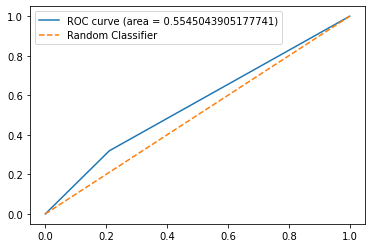

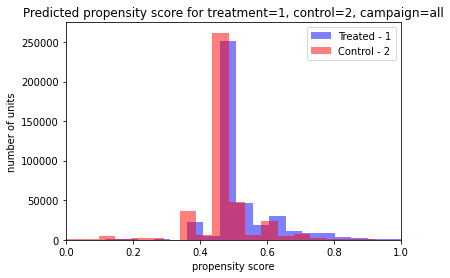

name=all, treatment, control = (1, 3)
DecisionTreeClassifier
best params: {'max_depth': 10}
best score (f1): 0.3781342476516462
Accuracy  0.5609452117467024
Brier  0.4390547882532975


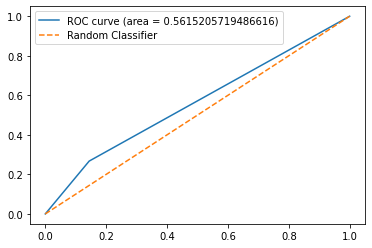

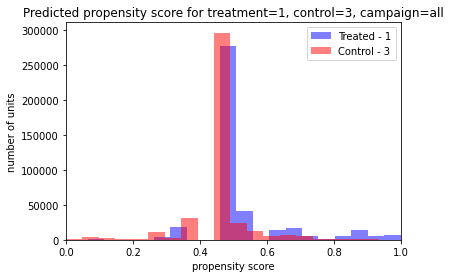

name=all, treatment, control = (2, 3)
DecisionTreeClassifier
best params: {'max_depth': 8}
best score (f1): 0.5697403365784178
Accuracy  0.5192799619881371
Brier  0.4807200380118629


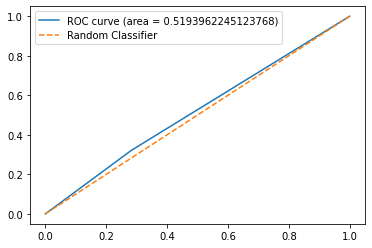

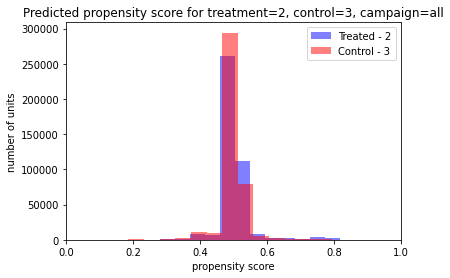

name=men, treatment, control = (1, 2)
DecisionTreeClassifier
best params: {'max_depth': 12}
best score (f1): 0.5071747256491972
Accuracy  0.5484203120534111
Brier  0.45157968794658887


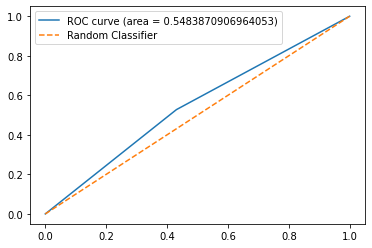

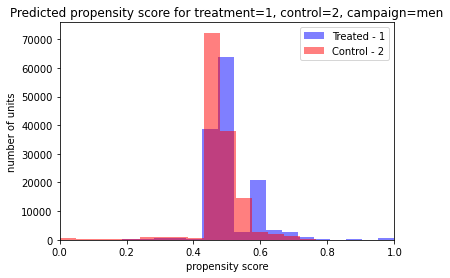

name=men, treatment, control = (1, 3)
DecisionTreeClassifier
best params: {'max_depth': 8}
best score (f1): 0.6055887735614878
Accuracy  0.5501766862656859
Brier  0.449823313734314


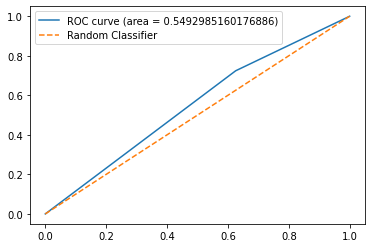

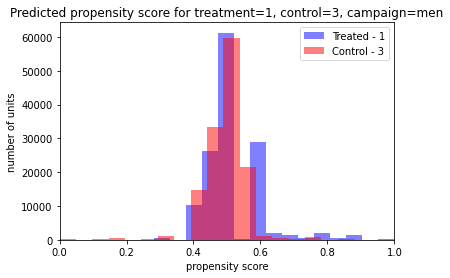

name=men, treatment, control = (2, 3)
DecisionTreeClassifier
best params: {'max_depth': 6}
best score (f1): 0.5634091584061024
Accuracy  0.5327465566767328
Brier  0.4672534433232673


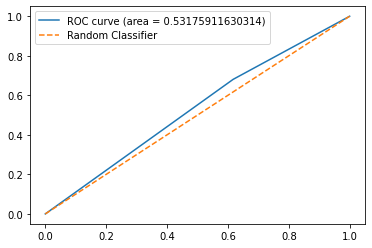

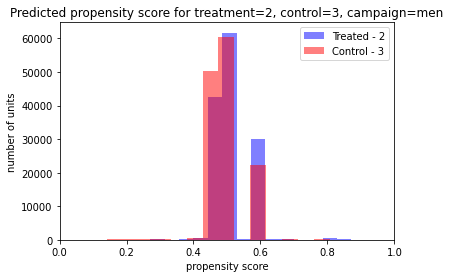

name=women, treatment, control = (1, 2)
DecisionTreeClassifier
best params: {'max_depth': 14}
best score (f1): 0.37322403939498194
Accuracy  0.5515715962282464
Brier  0.44842840377175364


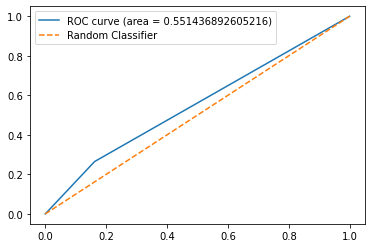

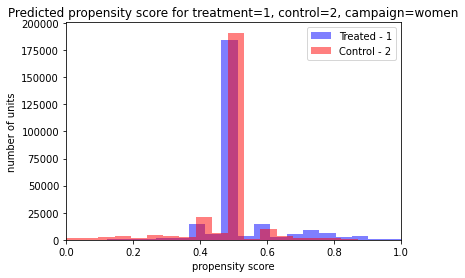

name=women, treatment, control = (1, 3)
DecisionTreeClassifier
best params: {'max_depth': 14}
best score (f1): 0.3520505184297758
Accuracy  0.5613233144271862
Brier  0.43867668557281375


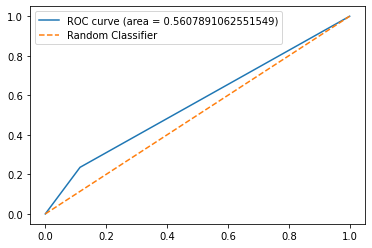

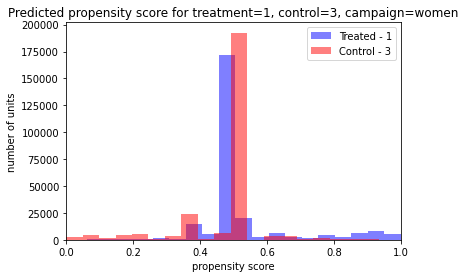

name=women, treatment, control = (2, 3)
DecisionTreeClassifier
best params: {'max_depth': 10}
best score (f1): 0.4289445326132188
Accuracy  0.5218177676889342
Brier  0.4781822323110658


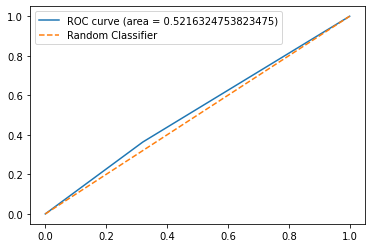

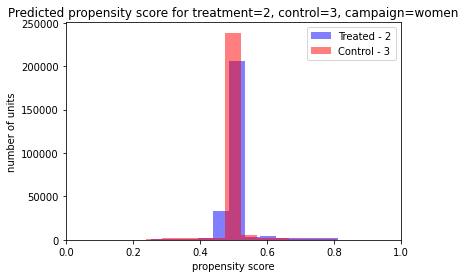

In [ ]:
# define kind of classifier
kind = 'DecisionTreeClassifier'

# define data

data_dict = dict(all=np.load('all_sample.npy'),
                 men=np.load('men_sample.npy'),
                 women=np.load('women_sample.npy'))

for name, npy_file in data_dict.items():
  for treatment, control in [(1,2), (1,3), (2,3)]:
    print(f'name={name}, treatment, control = {(treatment, control)}')
    not_included = [x for x in [1, 2, 3] if x not in [treatment, control]][0]
    data = npy_file[npy_file[:,0] != not_included]  # filtered (without the third possible treatment)
    T = np.array([1 if t == treatment else 0 for t in data[:,0]])
    Y = data[:,1]
    X = data[:,2:]

    pr , _ = propensity_score_numpy(X=X, T=T, treatment=treatment, control=control, kind=kind, name=name)
    
    np.save(f'propensity_score_numpy_{name}_treatment={treatment}_control={control}_kind={kind}.npy', pr)

    plot_propensity_graph_numpy(T=T, name=name, predicted_propensity=pr[:,-1], # propability of getting treatment 
                                treatment=treatment, control=control)

# Trim data by the propensity graphs and save the trimmed data

In [ ]:
# trim the samples with propensity scores that are between 0.95-1.00 or 0.00-0.05
def trim_and_save_new_npy(name, treatment, control):
    npy_file = np.load(f'{name}_sample.npy')
    prop = np.load(f'propensity_score_numpy_{name}_treatment={treatment}_control={control}_kind=DecisionTreeClassifier.npy')[:, -1]

    not_included = [x for x in [1, 2, 3] if x not in [treatment, control]][0]
    data = npy_file[npy_file[:, 0] != not_included]  # filtered (without the third possible treatment)
    # data[0] = [T, Y, ...rest of features...]
    idxes = np.ndarray.flatten(np.argwhere((prop >= 0.05) & (prop <= 0.95)))
    np.save(f'{name}_sample_treatment={treatment}_control={control}_trimmed.npy', data[idxes])
    np.save(f'trimmed_propensity_score_numpy_{name}_treatment={treatment}_control={control}_kind=DecisionTreeClassifier.npy', prop[idxes])

for name in ['all', 'men', 'women']:
  for treatment, control in [(1,2), (1,3), (2,3)]:
    trim_and_save_new_npy(name, treatment, control)

# Learners

In [ ]:
################################################################
# used for RCT data (Uniform Random data)
################################################################
def naive_ate(df, treatment, control):
  """
    calculate mean(CTR(treatment)) - mean(CTR(control))
    
    df: (pd.DataFrame)
    treatment: (int) a choice from {1,2,3}  
    control: (int) a choice from {1,2,3}
  """
  return np.mean(df[df['position'] == treatment]['click']) - np.mean(df[df['position'] == control]['click'])

################################################################
# used for the observational study data (BTS data)
################################################################
def s_learner(df, treatment, control, f1_dict):
  # filter dataframe for only specific treatment and control
  df_ = df[df['position'].isin({treatment, control})]
  assert len(df_) == len(df)
  T = [1 if p == treatment else 0 for p in df_['position']]
  df_['T'] = T
  Y = df_['click']
  X = df_.drop(['position', 'click'], axis=1)
  
  # X includes treatment column ('T')
  model, f1 = train_classifier(X, Y, class_weight=None) # very high un-balance
  f1_dict['s learner x->y'].append(f1)

  # assign treatment 1 to all
  X['T'] = 1
  pred1 = model.predict(X)
  X['T'] = 0
  pred0 = model.predict(X)

  ATE = np.mean(pred1 - pred0)

  return ATE

def t_learner(npy_file, treatment, control, f1_dict):
  not_included = [x for x in [1, 2, 3] if x not in [treatment, control]][0]
  
  # filter dataframe for specific treatment 
  data_1 = npy_file[npy_file[:,0] == treatment]
  # data_1[0] = [T, Y, ...rest of features...]
  Y_1 = data_1[:,1]
  X_1 = data_1[:,2:]

  # fit a model on treatment
  # possibly use class_weight='balanced' due to very high unbalanced outcome
  model_1, f1 = train_classifier(X_1, Y_1, class_weight=None)
  f1_dict['t learner x1->y1'].append(f1)
  # filter dataframe for specific control
  data_0 = npy_file[npy_file[:,0] == control]
  # data_0[0] = [T, Y, ...rest of features...]
  Y_0 = data_0[:,1]
  X_0 = data_0[:,2:]

  # fit a model on control
  # possibly use class_weight='balanced' due to very high unbalanced outcome
  model_0, f1 = train_classifier(X_0, Y_0, class_weight=None) 
  f1_dict['t learner x0->y0'].append(f1)

  # predict on all the data, by each model
  data = npy_file[npy_file[:,0] != not_included]
  X = data[:,2:]

  pred1 = model_1.predict(X)
  pred0 = model_0.predict(X)

  ATE = np.mean(pred1 - pred0)

  return ATE

def ipw_learner(npy_file, treatment, control, propensity_npy_file_path):
  """
  propensity_npy_file_path: (str) path to .npy file with propensity
  """
  # filter dataframe for specific treatment
  not_included = [x for x in [1, 2, 3] if x not in [treatment, control]][0]
  data = npy_file[npy_file[:,0] != not_included]
  T = np.array([1 if t == treatment else 0 for t in data[:,0]])
  Y = data[:,1]
  X = data[:,2:]

  propensity = np.load(propensity_npy_file_path)
  propensity = propensity
  
  left_factor = np.nanmean(T * Y / propensity)
  right_factor = np.nanmean((1 - T) * Y / (1 - propensity))
  
  return left_factor - right_factor

# didn't use at the end because of computational burden
def matching_np(npy_file, treatment, control):
  # filter dataframe for specific treatment 
  data_1 = npy_file[npy_file[:,0] == treatment]
  # data_1[0] = [T, Y, ...rest of features...]
  Y_1 = data_1[:,1]
  X_1 = data_1[:,2:]

  # filter dataframe for specific control
  data_0 = npy_file[npy_file[:,0] == control]
  # data_0[0] = [T, Y, ...rest of features...]
  Y_0 = data_0[:,1]
  X_0 = data_0[:,2:]

  knn = NearestNeighbors(1)
  knn.fit(X_0) # train on control

  _, indices = knn.kneighbors(X_1) # find indices from control that are closest to every treated unit
  indices = np.ndarray.flatten(indices)

  y_neighbour = Y_0[indices] 

  return np.mean(Y_1 - y_neighbour)

# Run learners on undersampled data

## 10% sapmles undersampled (balanced/unbalanced outcome weights)

In [ ]:
# prepare dataframes to hold ATEs of learners
results = dict()
for method in ['s learner', 't leraner', 'ipw']:
  data = [[0,0,0],
          [0,0,0],
          [0,0,0]]
  df = pd.DataFrame(data, columns=['all', 'men', 'women'])
  df['(treatment,control)'] = ["(1,2)", "(1,3)", "(2,3)"]
  df = df.set_index('(treatment,control)')
  results[method] = df

for name in ['all', 'men', 'women']:
  for treatment, control in [(1,2), (1,3), (2,3)]:
    npy_file = np.load(f'{name}_sample_treatment={treatment}_control={control}_trimmed.npy')
    propensity_npy_file_path = f'trimmed_propensity_score_numpy_{name}_treatment={treatment}_control={control}_kind=DecisionTreeClassifier.npy'

    df = pd.DataFrame(npy_file, columns=['position', 'click'] + [f'{i}' for i in range(npy_file.shape[1] - 2)])

    method = 's learner'
    results[method].loc[f'({treatment},{control})', name] = s_learner(df, treatment, control, f1_dict=unbalanced_10_prec_f1)
    method = 't leraner'
    results[method].loc[f'({treatment},{control})', name] = t_learner(npy_file, treatment, control, f1_dict=unbalanced_10_prec_f1)
    method = 'ipw'
    results[method].loc[f'({treatment},{control})', name] = ipw_learner(npy_file, treatment, control, propensity_npy_file_path)

## undersampling ~1% of data

for every (treatment,control,campaign) leave all the 'n' rows with click=1 and sample 'n' rows with click=0

### create and save the 1% data

In [ ]:
# take the 10% data that contains all the available click=1 rows from the original data and reduce the #rows of class click=0 to be the same class click=1
for name in ['all', 'men', 'women']:
  for treatment, control in [(1,2), (1,3), (2,3)]:
    npy_file = np.load(f'{name}_sample_treatment={treatment}_control={control}_trimmed.npy')
    propensity_npy_file_path = f'trimmed_propensity_score_numpy_{name}_treatment={treatment}_control={control}_kind=DecisionTreeClassifier.npy'
    prop = np.load(propensity_npy_file_path)

    # indices of click = 1 and click = 0
    all_idxes_1 = np.ndarray.flatten(np.argwhere(npy_file[:,1] == 1))
    all_idxes_0 = np.ndarray.flatten(np.argwhere(npy_file[:,1] == 0))
    sample_idxes_0 = np.random.choice(all_idxes_0, size=len(all_idxes_1), replace=False)

    indices = np.hstack((all_idxes_1, sample_idxes_0))
    
    new_file, new_prop = npy_file[indices], prop[indices]
    np.save(f'undersampled_npy_file_{name}_treatment={treatment}_control={control}.npy', new_file)
    np.save(f'undersampled_propensity_score_numpy_{name}_treatment={treatment}_control={control}_kind=DecisionTreeClassifier.npy', new_prop)

### undersampled (count(click=1) == count(click=0)) for every treatment,conrol,campaign 

In [ ]:
# prepare dataframes to hold ATEs of learners
results = dict()
for method in ['s learner', 't leraner', 'ipw']:
  data = [[0,0,0],
          [0,0,0],
          [0,0,0]]
  df = pd.DataFrame(data, columns=['all', 'men', 'women'])
  df['(treatment,control)'] = ["(1,2)", "(1,3)", "(2,3)"]
  df = df.set_index('(treatment,control)')
  results[method] = df

for name in ['all', 'men', 'women']:
  for treatment, control in [(1,2), (1,3), (2,3)]:
    print('\n--name, treatment, control: ', name, treatment, control)
    npy_file = np.load(f'undersampled_npy_file_{name}_treatment={treatment}_control={control}.npy')
    propensity_npy_file_path = f'undersampled_propensity_score_numpy_{name}_treatment={treatment}_control={control}_kind=DecisionTreeClassifier.npy'

    df = pd.DataFrame(npy_file, columns=['position', 'click'] + [f'{i}' for i in range(npy_file.shape[1] - 2)])

    method = 's learner'
    results[method].loc[f'({treatment},{control})', name] = s_learner(df, treatment, control, f1_dict=undersampling_f1)
    method = 't leraner'
    results[method].loc[f'({treatment},{control})', name] = t_learner(npy_file, treatment, control, f1_dict=undersampling_f1)
    method = 'ipw'
    results[method].loc[f'({treatment},{control})', name] = ipw_learner(npy_file, treatment, control, propensity_npy_file_path)

# Evaluation

## Naive ATE calculation on RCT data (Uniform Random)

In [ ]:
def naive_ate_with_ci(df, treatment, control):
   p2 = np.mean(df[df['position'] == treatment]['click']) 
   p1 = np.mean(df[df['position'] == control]['click'])
   n2 = len(df[df['position'] == treatment]['click'])
   n1 = len(df[df['position'] == control]['click'])
   delta = np.sqrt(p1 * (1 - p1) / (n1 ** 2) + p2 * (1 - p2) / (n2 ** 2))
   diff = p2 - p1
   return diff, [round(diff - 1.96 * delta,6), round(diff + 1.96 * delta,6)]

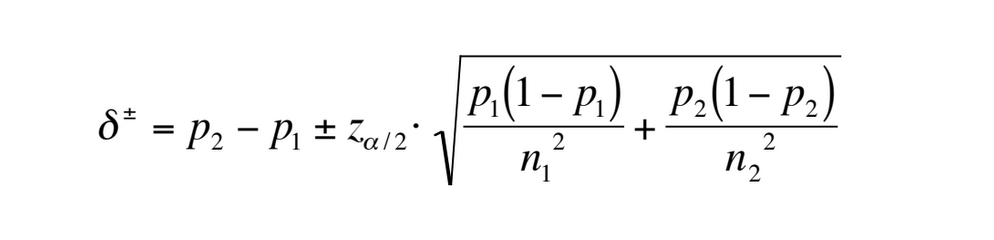

In [ ]:
men_path_random = '/content/open_bandit_dataset/random/men/men.csv'
men_items_path_random = '/content/open_bandit_dataset/random/men/item_context.csv'
women_path_random = '/content/open_bandit_dataset/random/women/women.csv'
women_items_path_random = '/content/open_bandit_dataset/random/women/item_context.csv'
all_path_random = '/content/open_bandit_dataset/random/all/all.csv'
all_items_path_random = '/content/open_bandit_dataset/random/all/item_context.csv'

df_path_list = [men_path_random,women_path_random,all_path_random]
item_path_list = [men_items_path_random,women_items_path_random,all_items_path_random]
df_names = ['men','women','all']
ate = {} 
for name, df_path, item_path in zip(df_names,df_path_list,item_path_list):
  df = load_dataset(df_path,item_path,rows=None)
  ate_12, ci_12 = naive_ate_with_ci(df,1,2)
  ate_13, ci_13 = naive_ate_with_ci(df,1,3)
  ate_23, ci_23 = naive_ate_with_ci(df,2,3)
  ate[name]= {'ate_12' : [ate_12, ci_12] , 'ate_13' : [ate_13,ci_13], 'ate_23' : [ate_23,ci_23]  }

for name, ate_dict in ate.items():
  print(f"For {name} dataset, the ate of position 1-2 is {ate_dict['ate_12'][0]}, CI: {ate_dict['ate_12'][1]} \n"
        f"For {name} dataset, the ate of position 1-3 is {ate_dict['ate_13'][0]}, CI: {ate_dict['ate_13'][1]}\n"
        f"For {name} dataset, the ate of position 2-3 is {ate_dict['ate_23'][0]}, CI: {ate_dict['ate_23'][1]}\n")


For men dataset, the ate of position 1-2 is 0.0001350083636615677, CI: [0.000134, 0.000136] 

For men dataset, the ate of position 1-3 is 0.0006315764622958232, CI: [0.00063, 0.000633]

For men dataset, the ate of position 2-3 is 0.0004965680986342555, CI: [0.000495, 0.000498]



For women dataset, the ate of position 1-2 is 7.805161195316782e-05, CI: [7.7e-05, 7.9e-05] 

For women dataset, the ate of position 1-3 is -3.0037321997285725e-05, CI: [-3.1e-05, -2.9e-05]

For women dataset, the ate of position 2-3 is -0.00010808893395045354, CI: [-0.000109, -0.000107]



For all dataset, the ate of position 1-2 is 7.102755216819223e-05, CI: [7.1e-05, 7.1e-05] 

For all dataset, the ate of position 1-3 is 0.00014528223501322464, CI: [0.000145, 0.000146]

For all dataset, the ate of position 2-3 is 7.425468284503241e-05, CI: [7.4e-05, 7.5e-05]


## Mean Absolute Percentage Error

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Success Rate

In [ ]:
def calculate_success_rate(y_true, y_pred):
  return sum([1 if x*y > 0  else 0 for x,y in zip(y_true, y_pred)]) /len(y_true)